In [1]:
import random
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import manifold

def seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [241]:
def get_metrics(paths):
    metrics = []
    for path in paths:
        metrics.append(torch.load(path, map_location='cpu'))
    return metrics

def tsne(x):
    tsne = manifold.TSNE(n_components=2, method='barnes_hut', metric='cosine', init='random', random_state=0)
    x_tsne = tsne.fit_transform(x)
    return x_tsne

def umap(x):
    import umap
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine')
    x_umap = reducer.fit_transform(x)
    return x_umap

freqs = pd.read_csv('../metadata/freqs/class_frequency_laion400m_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs = np.argsort(freqs)[::-1]

def get_plot_cls_results(path, plot_func, use_cls=True):
    feature_dict = torch.load(path, map_location='cpu')
    if use_cls:
        classifiers = feature_dict['classifiers']['openai']
    else:
        classifiers = feature_dict['features'].mean(dim=1)
    classifiers = F.normalize(classifiers, dim=-1, p=2)
    X_tsne = plot_func(classifiers)

    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)
    return X_norm

def plot_tsne_cls(ax, X_norm):
    ax.set_box_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    nodes = [0, .03, .1, .9, .97, 1]
    colors = [("tab:green", 1), ("tab:green", 0.5), ("tab:blue", 0.06), ("tab:blue", 0.06), ("tab:purple", 0.5), ("tab:purple", 1)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(None, list(zip(nodes, colors)))
    pos = ax.scatter(X_norm[idxs, 0], X_norm[idxs, 1], c=range(1000)[::-1], cmap=cmap, marker='+', s=50, lw=2)
    cbar = fig.colorbar(pos, ax=ax, pad=0.03, shrink=1, aspect=25)
    cbar.set_ticks([0, 1000])
    cbar.set_ticklabels(['', ''])
    cbar.ax.text(1.7, 0, 'Tail', rotation=90, ha='left', va='bottom', fontsize=12)
    cbar.ax.text(1.7, 1000, 'Head', rotation=90, ha='left', va='top', fontsize=12)
    return cbar

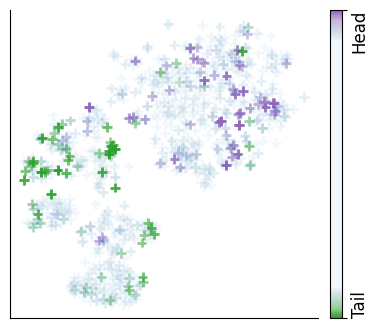

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Note: run ../tools/extract_val_features.py to get features on pre-trained models on ImageNet validation set
path = '../exps_clip/logs_pretrained/ViT-B-32-laion400m_e32/imagenet_val_features.pt'
# path = '../exps_clip/logs_pretrained/ViT-B-32-laion2b_s34b_b79k/imagenet_val_features.pt'
X_norm = get_plot_cls_results(path, tsne, use_cls=True)
cbar = plot_tsne_cls(ax, X_norm)
ax.set_box_aspect(1)
# ax.set_title('CLIP text class centers (t-SNE)', fontsize=12)
plt.savefig('figs_new/tsne_text_centers.pdf', bbox_inches='tight', dpi=300)

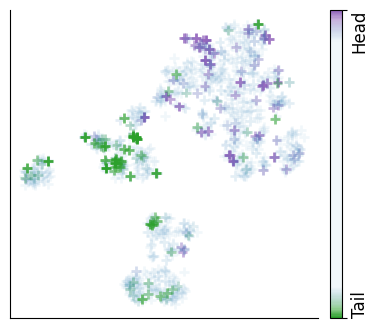

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

path = '../exps_clip/logs_pretrained/ViT-B-32-laion400m_e32/imagenet_val_features.pt'
# path = '../exps_clip/logs_pretrained/ViT-B-32-laion2b_s34b_b79k/imagenet_val_features.pt'
X_norm = get_plot_cls_results(path, tsne, use_cls=False)
cbar = plot_tsne_cls(ax, X_norm)
ax.set_box_aspect(1)
# ax.set_title('CLIP text class centers (t-SNE)', fontsize=12)
plt.savefig('figs_new/tsne_vision_centers.pdf', bbox_inches='tight', dpi=300)

In [323]:
freqs = pd.read_csv('../metadata/freqs/class_frequency_laion400m_imagenet_ori.txt', sep='\t', header=None, names=['class', 'freq'])['freq'].to_numpy()
idxs = np.argsort(freqs)[::-1]

def get_tsne_results(path, plot_func, num_tail_classes=5, num_head_classes_to_sample=50, num_samples_per_class=50, use_classifiers=False, sd=42):
    seed(sd)
    
    feature_dict = torch.load(path, map_location='cpu')
    features = feature_dict['features'].numpy()[idxs]
    classifiers = features.mean(axis=1)

    idxs_head = np.random.choice(num_head_classes_to_sample*20, num_head_classes_to_sample, replace=False)
    idxs_head = sorted(idxs_head)
    idxs_tail = np.random.choice(num_tail_classes*5, num_tail_classes, replace=False)
    idxs_tail = sorted(idxs_tail)
    idxs_tail = [item + len(freqs) - num_tail_classes*5 for item in idxs_tail]
    features = np.concatenate([features[idxs_head], features[idxs_tail]])
    features = features[:, :num_samples_per_class]

    if use_classifiers:
        classifiers = np.concatenate([classifiers[idxs_head], classifiers[idxs_tail]])
        flattened_features = np.concatenate([classifiers, features.reshape(-1, features.shape[-1])])
    else:
        flattened_features = features.reshape(-1, features.shape[-1])
    X_tsne = plot_func(flattened_features)

    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)

    if use_classifiers:
        X_norm_proto, X_norm_feats = X_norm[:classifiers.shape[0]], X_norm[classifiers.shape[0]:]
    else:
        X_norm_proto, X_norm_feats = None, X_norm
    
    X_norm_feats = X_norm_feats.reshape(features.shape[0], num_samples_per_class, 2)
    return idxs_head, idxs_tail, X_norm_proto, X_norm_feats

def plot_tsne(idxs_head, idxs_tail, X_norm_proto, X_norm_feats, num_samples_per_class=50):
    ax.set_box_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    nodes = [0, .01, .1, .6, .9, 1]
    colors = [("tab:green", .5), ("tab:green", .1), ("tab:blue", 0.01), ("tab:blue", 0.01), ("tab:purple", .1), ("tab:purple", .7)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(None, list(zip(nodes, colors)))
    c = -1 * np.concatenate([idxs_head, idxs_tail])
    c_all = c[np.newaxis].repeat(num_samples_per_class, axis=1).reshape(-1)
    pos_head = ax.scatter(X_norm_feats.reshape(-1, 2)[:, 0], X_norm_feats.reshape(-1, 2)[:, 1], c=c_all, cmap=cmap, vmin=-999, vmax=1, s=20, label='samples')

    if X_norm_proto is not None:
        ax.scatter(X_norm_proto[:, 0], X_norm_proto[:, 1], marker='+', c='w', s=30, lw=1.5, alpha=.8, label='centers')

    cbar = fig.colorbar(pos_head, ax=ax, pad=0.03, shrink=1, aspect=25)
    cbar.set_ticks([-999, 0])
    cbar.set_ticklabels(['', ''])
    cbar.ax.text(1.7, -999, 'Tail', rotation=90, ha='left', va='bottom', fontsize=12)
    cbar.ax.text(1.7, 1, 'Head', rotation=90, ha='left', va='top', fontsize=12)
    return cbar

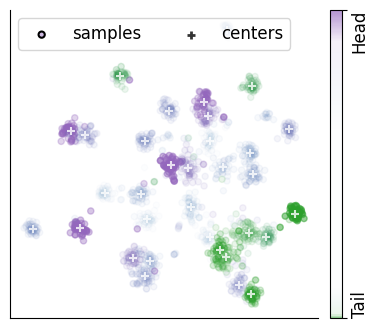

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

path = '../exps_clip/logs_pretrained/ViT-B-32-laion400m_e32/imagenet_val_features.pt'
# path = '../exps_clip/logs_pretrained/ViT-B-32-laion2b_s34b_b79k/imagenet_val_features.pt'
num_tail_classes = 8
num_head_classes_to_sample, num_samples_per_class = 25, 50

idxs_head, idxs_tail, X_norm_proto, X_norm_feats = get_tsne_results(path, tsne, num_tail_classes, num_head_classes_to_sample, num_samples_per_class, True, sd=5)
cbar = plot_tsne(idxs_head, idxs_tail, X_norm_proto, X_norm_feats, num_samples_per_class)
ax.set_box_aspect(1)
leg = ax.legend(loc='upper left', fontsize=12, ncols=2)
leg.legend_handles[0].set_lw(1.5)
leg.legend_handles[1].set_lw(2)
leg.legend_handles[0].set_color('black')
leg.legend_handles[1].set_color('black')
# ax.set_title('CLIP text class centers (t-SNE)', fontsize=12)
plt.savefig('figs_new/tsne_vision_feats.pdf', bbox_inches='tight', dpi=300)